# 5.4 Binomial Logistic Regression

In [5]:
import os, sys

cwd = os.getcwd()
if '\\' in cwd:
    cwd_parts = cwd.split('\\')
else:
    cwd_parts = cwd.split('/')
current_dir = cwd_parts[-1]
if current_dir != 'chap05':
    os.chdir('../../chap05')
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\yongd\Documents\git\Matsuura2022_Bayesian_Statistical_Modeling\chap05


In [24]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

d = pandas.read_csv('input/data-shopping-3.csv')
d.Income /= 100
# d.drop(columns='PersonID', inplace=True)

data = d.to_dict('list')
data.update({'N':len(d)})

d.tail()

PersonID  Sex  Income  Discount  Y
439        50    1     0.7         0  1
440        50    1     0.7         0  0
441        50    1     0.7         0  1
442        50    1     0.7         0  1
443        50    1     0.7         0  1

## Check Data Distribution

<Figure size 1000x600 with 0 Axes>

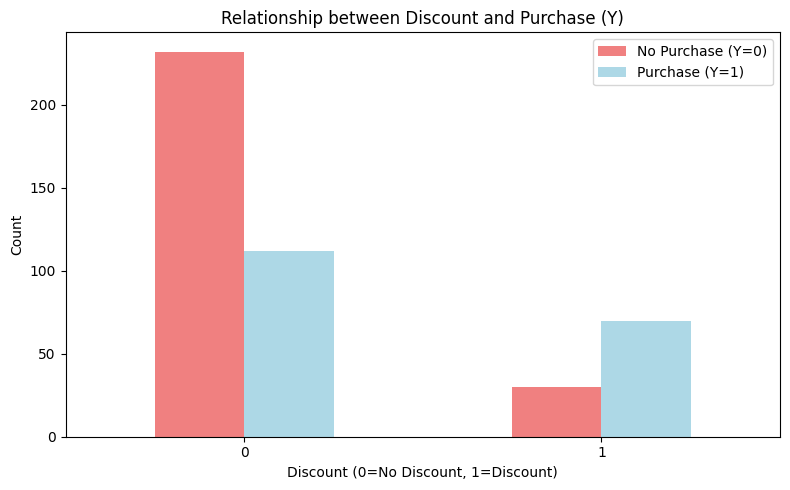

Proportion table (Discount vs Y):
Y                0         1
Discount                    
0         0.674419  0.325581
1         0.300000  0.700000


In [25]:
# Create a plot showing the relationship between Discount and Y
plt.figure(figsize=(10, 6))

# Create a cross-tabulation to get counts
discount_y_crosstab = pandas.crosstab(d['Discount'], d['Y'])

# Create a grouped bar plot
discount_y_crosstab.plot(kind='bar', 
                        title='Relationship between Discount and Purchase (Y)',
                        xlabel='Discount (0=No Discount, 1=Discount)',
                        ylabel='Count',
                        color=['lightcoral', 'lightblue'],
                        figsize=(8, 5))

plt.legend(['No Purchase (Y=0)', 'Purchase (Y=1)'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Also show proportions
print("Proportion table (Discount vs Y):")
proportion_table = pandas.crosstab(d['Discount'], d['Y'], normalize='index')
print(proportion_table)

## Data Generating Mechanism & Stan

In [26]:
import cmdstanpy
model = cmdstanpy.CmdStanModel(stan_file='model/model5-5.stan')

In [27]:
print(model.code())

data {
  int V;
  vector<lower=0, upper=1>[V] Sex;
  vector<lower=0>[V] Income;
  vector<lower=0, upper=1>[V] Dis;
  array[V] int <lower=0, upper=1> Y;
}

parameters {
  vector[4] b;
}

transformed parameters {
  vector[V] q = inv_logit(
    b[1] + b[2]*Sex[1:V] + b[3]*Income[1:V] + b[4]*Dis[1:V]);
}

model {
  Y[1:V] ~ bernoulli(q[1:V]);
}



### Model Formula 5.5

$$
\begin{align}
    q[n]  & =  \mathrm{inv\_logit}(b_1 + b_2 Sex[n] + b_3 Income[n] + b_4 Dis[n]), \quad\quad n=1,...,N \\
    Y[n]  & \sim  \mathrm{Binomial}(M[n], q[n])
\end{align}
$$

In [31]:
# input data to Stan
data = {'V': len(d),  # N -> V
        'Sex': d['Sex'].tolist(),
        'Income': d['Income'].tolist(),
        'Dis': d['Discount'].tolist(),
        'Y': d['Y'].tolist()}

In [33]:
# Suppress all output from model.sample() including logger messages
import warnings
import sys
from contextlib import redirect_stdout, redirect_stderr
import os
import logging

# Suppress cmdstanpy logger messages completely
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# Or use CRITICAL to suppress even warnings: logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)

# Method 1: Use show_console=False (most effective)
fit = model.sample(data=data, seed=123, show_console=False, show_progress=False)

print("Sampling completed.")
fit.summary()

Sampling completed.


Mean      MCSE    StdDev       MAD          5%         50%  \
lp__   -275.194000  0.041272  1.468460  1.178740 -278.046000 -274.838000   
b[1]     -2.007860  0.010881  0.445818  0.441760   -2.754810   -2.004730   
b[2]      0.262656  0.004739  0.217678  0.222511   -0.092739    0.260940   
b[3]      1.655670  0.014461  0.606604  0.615009    0.653841    1.660040   
b[4]      1.649540  0.004995  0.252533  0.247633    1.243960    1.648630   
...            ...       ...       ...       ...         ...         ...   
q[440]    0.358118  0.000537  0.031613  0.032261    0.307535    0.357995   
q[441]    0.358118  0.000537  0.031613  0.032261    0.307535    0.357995   
q[442]    0.358118  0.000537  0.031613  0.032261    0.307535    0.357995   
q[443]    0.358118  0.000537  0.031613  0.032261    0.307535    0.357995   
q[444]    0.358118  0.000537  0.031613  0.032261    0.307535    0.357995   

               95%  ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__   -273.542000   1444.11   1700.49     355.604  1.00059  
b[1]     -1.286030   1680.81   1780.30     413.890  1.00156  
b[2]      0.624745   2052.70   2002.22     505.467  1.00119  
b[3]      2.654320   1759.85   2025.19     433.355  1.00073  
b[4]      2.069650   2594.73   2390.14     638.939  1.00124  
...            ...       ...       ...         ...      ...  
q[440]    0.410448   3501.28   3045.09     862.173  1.00017  
q[441]    0.410448   3501.28   3045.09     862.173  1.00017  
q[442]    0.410448   3501.28   3045.09     862.173  1.00017  
q[443]    0.410448   3501.28   3045.09     862.173  1.00017  
q[444]    0.410448   3501.28   3045.09     862.173  1.00017  

[449 rows x 11 columns]

In [34]:
# Also suppress messages from model.optimize()
mapest = model.optimize(data=data, seed=123, show_console=False)
print(mapest.b)

[-1.9963732   0.26407964  1.6432228   1.6343965 ]


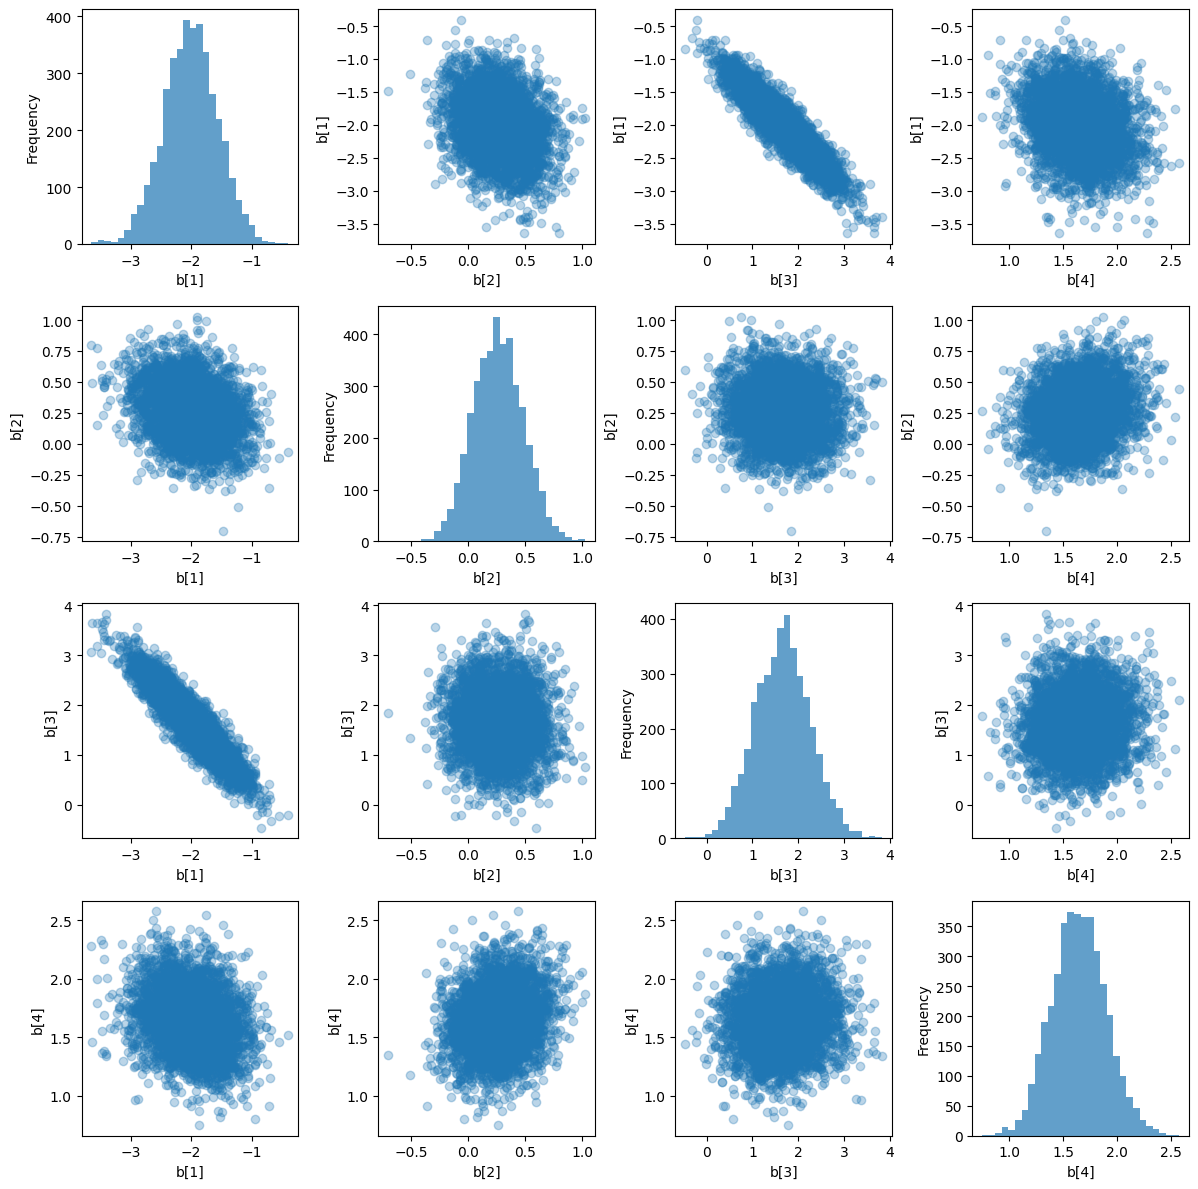

In [38]:
# Extract parameters b[1], b[2], b[3] from the fit
samples = fit.draws_pd()
b_params = samples[['b[1]', 'b[2]', 'b[3]', 'b[4]']]

# Create 3x3 scatter plot matrix
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

param_names = ['b[1]', 'b[2]', 'b[3]', 'b[4]']

for i in range(4):
    for j in range(4):
        if i == j:
            # Diagonal: histograms
            axes[i, j].hist(b_params[param_names[i]], bins=30, alpha=0.7)
            axes[i, j].set_xlabel(param_names[i])
            axes[i, j].set_ylabel('Frequency')
        else:
            # Off-diagonal: scatter plots
            axes[i, j].scatter(b_params[param_names[j]], b_params[param_names[i]], alpha=0.3)
            axes[i, j].set_xlabel(param_names[j])
            axes[i, j].set_ylabel(param_names[i])

plt.tight_layout()
plt.show()

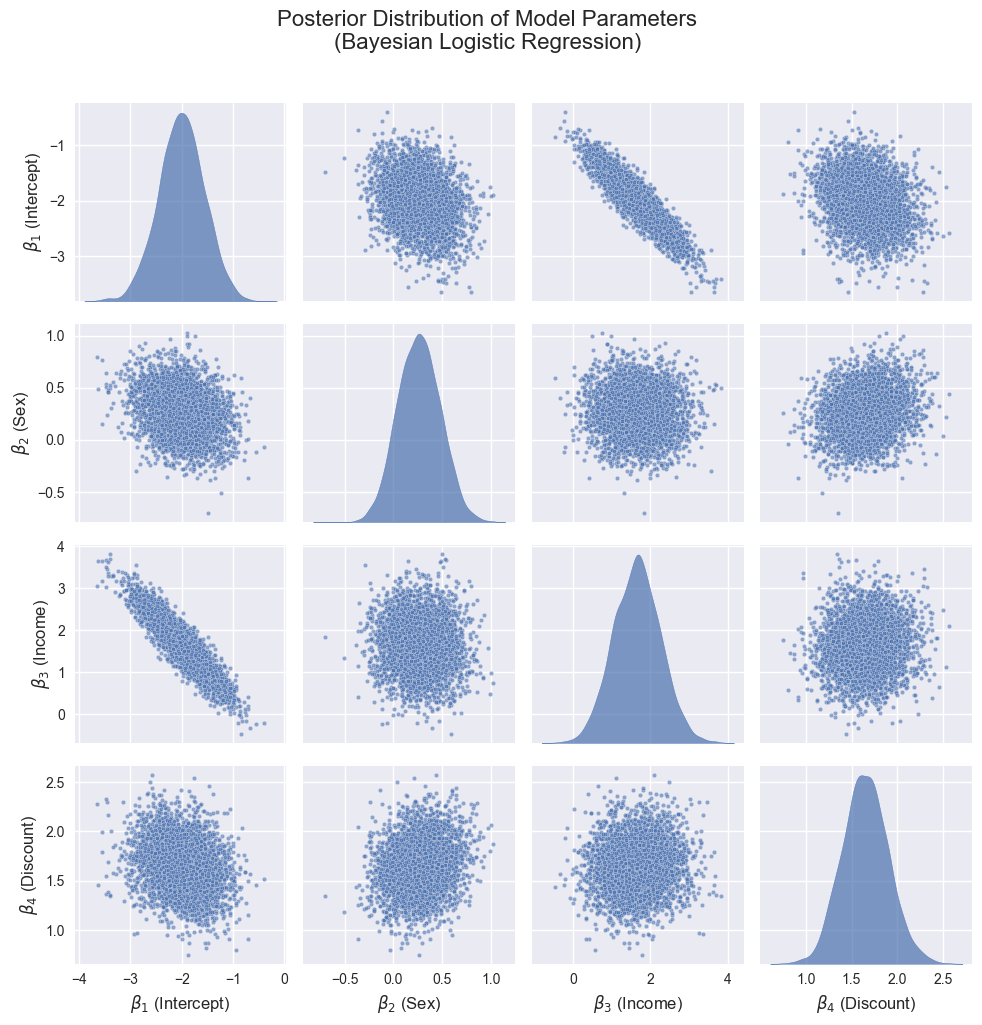

In [40]:
# Beautiful pairplot with enhanced styling
plt.style.use('seaborn-v0_8')  # Use seaborn style
g = sns.pairplot(data=b_params, 
                diag_kind='kde',  # Use KDE for diagonal instead of histogram
                plot_kws={'alpha': 0.6, 's': 10},  # More transparent points, smaller size
                diag_kws={'fill': True, 'alpha': 0.7})  # Shaded KDE

# Customize the figure
g.fig.suptitle('Posterior Distribution of Model Parameters\n(Bayesian Logistic Regression)', 
               fontsize=16, y=1.02)

# Add parameter labels with Greek letters
param_labels = [r'$\beta_1$ (Intercept)', r'$\beta_2$ (Sex)', r'$\beta_3$ (Income)', r'$\beta_4$ (Discount)']
for i, label in enumerate(param_labels):
    g.axes[i, 0].set_ylabel(label, fontsize=12)
    g.axes[-1, i].set_xlabel(label, fontsize=12)

plt.tight_layout()
plt.show()

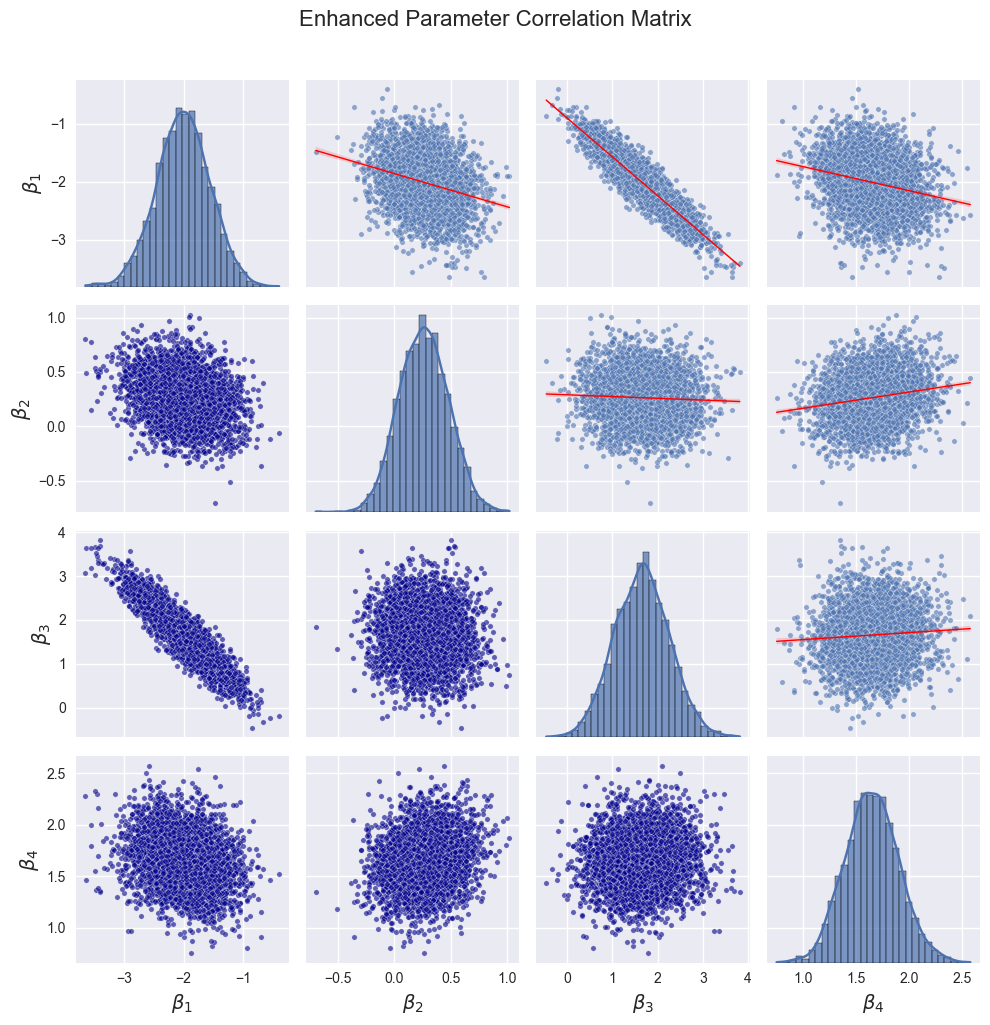

In [41]:
# Alternative 1: Custom PairGrid with more control
g = sns.PairGrid(b_params, height=2.5)

# Upper triangle: scatter plots with regression lines
g.map_upper(sns.scatterplot, alpha=0.6, s=15)
g.map_upper(sns.regplot, scatter=False, color='red', line_kws={'linewidth': 1})

# Lower triangle: scatter plots with different colors
g.map_lower(sns.scatterplot, alpha=0.6, s=15, color='darkblue')

# Diagonal: beautiful histograms with KDE overlay
g.map_diag(sns.histplot, kde=True, alpha=0.7, bins=30)

# Add titles and labels
g.fig.suptitle('Enhanced Parameter Correlation Matrix', fontsize=16, y=1.02)
param_labels = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\beta_4$']
for i, label in enumerate(param_labels):
    g.axes[i, 0].set_ylabel(label, fontsize=14)
    g.axes[-1, i].set_xlabel(label, fontsize=14)

plt.tight_layout()
plt.show()

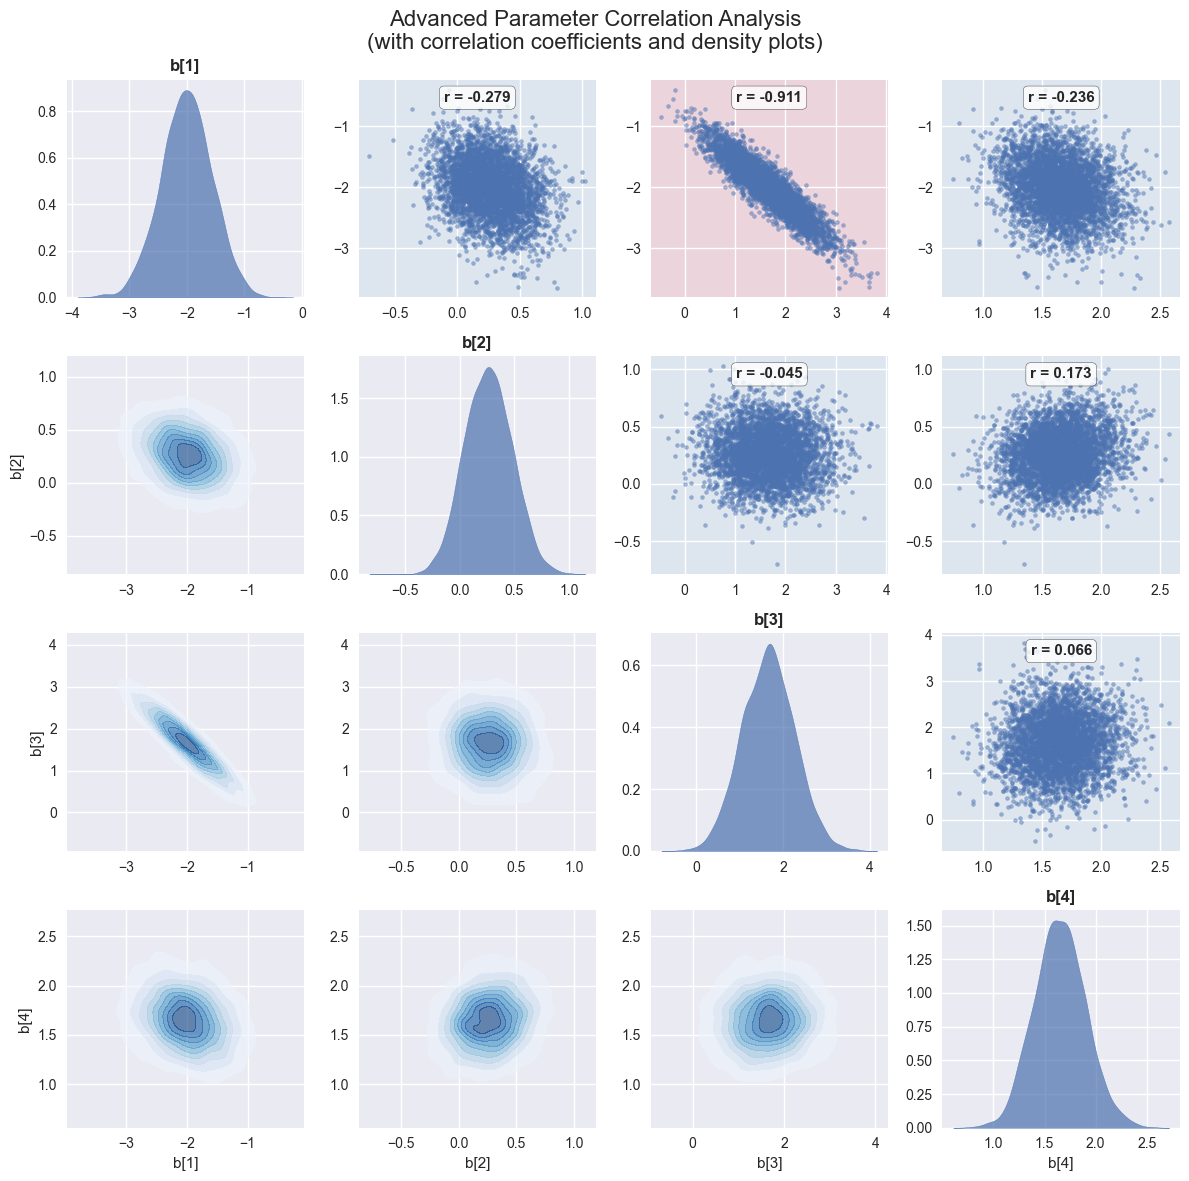

Parameter Correlation Matrix:
       b[1]   b[2]   b[3]   b[4]
b[1]  1.000 -0.279 -0.911 -0.236
b[2] -0.279  1.000 -0.045  0.173
b[3] -0.911 -0.045  1.000  0.066
b[4] -0.236  0.173  0.066  1.000


In [42]:
# Alternative 2: Correlation matrix with correlation coefficients
from scipy import stats
import matplotlib.patches as patches

# Calculate correlation matrix
corr_matrix = b_params.corr()

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
param_names = b_params.columns

for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: KDE plots with filled area
            sns.kdeplot(data=b_params, x=param_names[i], ax=ax, fill=True, alpha=0.7)
            ax.set_ylabel('')
            ax.set_title(f'{param_names[i]}', fontweight='bold')
            
        elif i < j:
            # Upper triangle: scatter with correlation coefficient
            x, y = b_params[param_names[j]], b_params[param_names[i]]
            correlation = corr_matrix.iloc[i, j]
            
            # Scatter plot
            ax.scatter(x, y, alpha=0.5, s=8)
            
            # Add correlation text
            ax.text(0.5, 0.95, f'r = {correlation:.3f}', 
                   transform=ax.transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=11, fontweight='bold')
            
            # Color background based on correlation strength
            if abs(correlation) > 0.7:
                color = 'lightcoral'
            elif abs(correlation) > 0.3:
                color = 'lightyellow'
            else:
                color = 'lightblue'
            ax.add_patch(patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                                         facecolor=color, alpha=0.2, zorder=0))
            
        else:
            # Lower triangle: 2D density plots
            sns.kdeplot(data=b_params, x=param_names[j], y=param_names[i], 
                       ax=ax, fill=True, alpha=0.6, cmap='Blues')
        
        # Clean up axes
        if i < 3:
            ax.set_xlabel('')
        if j > 0:
            ax.set_ylabel('')

plt.suptitle('Advanced Parameter Correlation Analysis\n(with correlation coefficients and density plots)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Print correlation matrix
print("Parameter Correlation Matrix:")
print(corr_matrix.round(3))

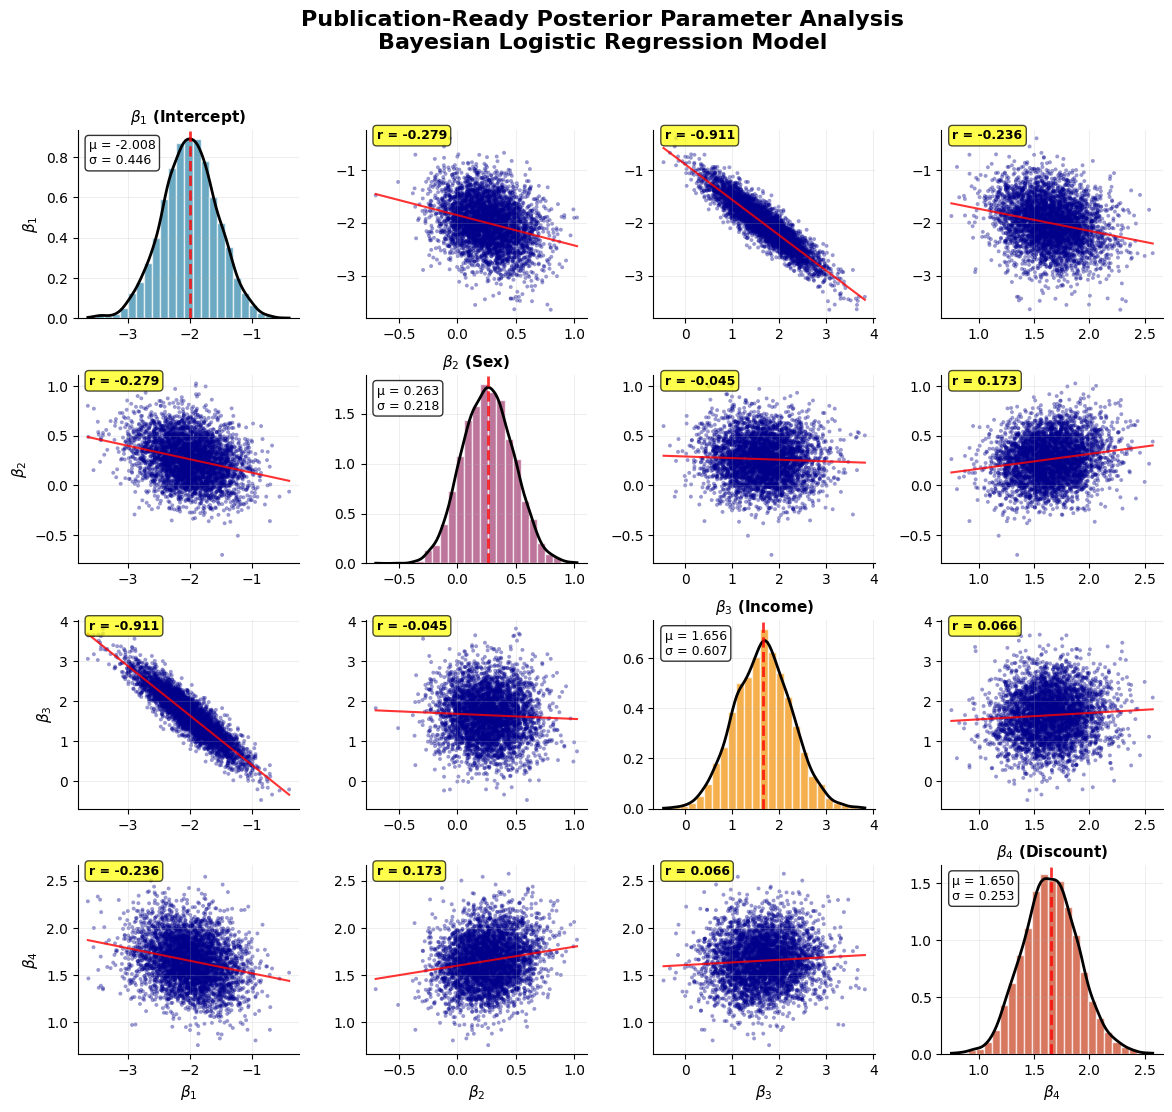

In [43]:
# Alternative 3: Professional publication-ready plot
import matplotlib.gridspec as gridspec

# Set up the plotting style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 10,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.bottom': True,
    'ytick.left': True,
})

# Create figure with custom layout
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(4, 4, hspace=0.3, wspace=0.3)

param_names = [r'$\beta_1$ (Intercept)', r'$\beta_2$ (Sex)', r'$\beta_3$ (Income)', r'$\beta_4$ (Discount)']
param_short = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\beta_4$']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        
        if i == j:
            # Diagonal: enhanced histograms with statistics
            data_col = b_params.iloc[:, i]
            
            # Histogram with KDE overlay
            n, bins, patches = ax.hist(data_col, bins=25, alpha=0.7, 
                                     color=colors[i], density=True, edgecolor='white')
            
            # KDE overlay
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data_col)
            x_range = np.linspace(data_col.min(), data_col.max(), 100)
            ax.plot(x_range, kde(x_range), color='black', linewidth=2)
            
            # Add statistics
            mean_val = data_col.mean()
            std_val = data_col.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, linewidth=2)
            
            # Statistics text
            stats_text = f'μ = {mean_val:.3f}\nσ = {std_val:.3f}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)
            
            ax.set_title(param_names[i], fontweight='bold', fontsize=11)
            
        else:
            # Off-diagonal: enhanced scatter plots
            x_data = b_params.iloc[:, j]
            y_data = b_params.iloc[:, i]
            
            # Create scatter plot with density coloring
            scatter = ax.scatter(x_data, y_data, c='darkblue', alpha=0.4, s=8, edgecolors='none')
            
            # Add regression line
            z = np.polyfit(x_data, y_data, 1)
            p = np.poly1d(z)
            ax.plot(x_data.sort_values(), p(x_data.sort_values()), 
                   color='red', linewidth=1.5, alpha=0.8)
            
            # Calculate and display correlation
            correlation = np.corrcoef(x_data, y_data)[0, 1]
            ax.text(0.05, 0.95, f'r = {correlation:.3f}', transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                   fontsize=9, fontweight='bold')
        
        # Label formatting
        if i == 3:  # Bottom row
            ax.set_xlabel(param_short[j], fontsize=11, fontweight='bold')
        if j == 0:  # Left column
            ax.set_ylabel(param_short[i], fontsize=11, fontweight='bold')
        
        # Grid
        ax.grid(True, alpha=0.3, linewidth=0.5)

plt.suptitle('Publication-Ready Posterior Parameter Analysis\nBayesian Logistic Regression Model', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

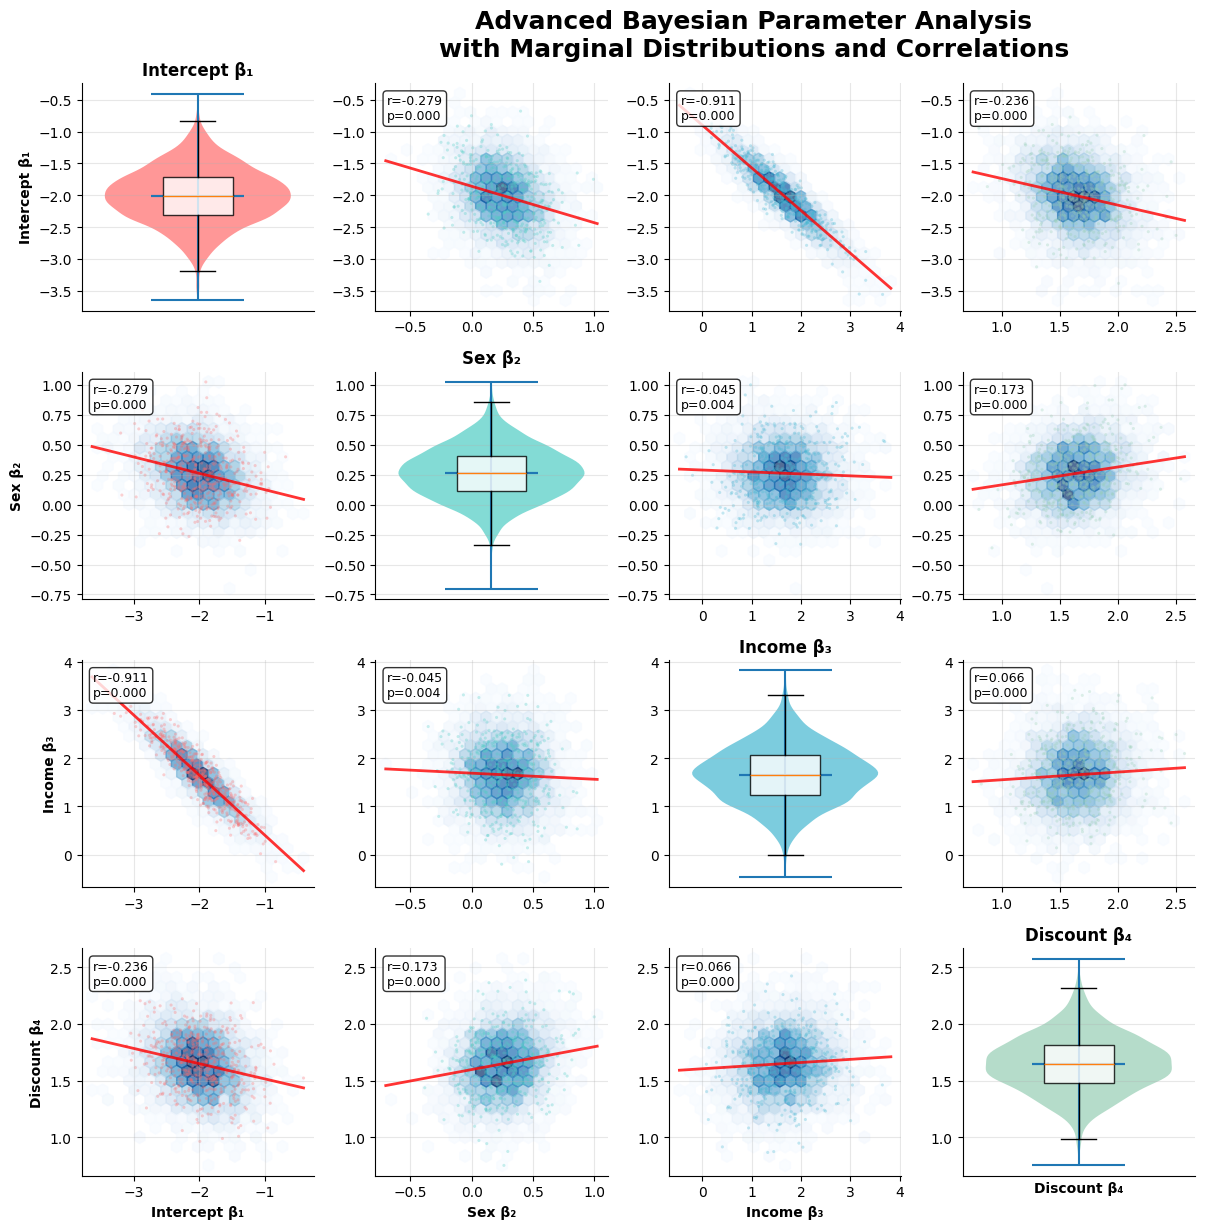

In [44]:
# Alternative 4: Interactive-style plot with marginal distributions
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Remove extra axes
for i in range(4, 5):
    for j in range(5):
        fig.delaxes(axes[i, j])
for i in range(5):
    for j in range(4, 5):
        if i < 4:
            fig.delaxes(axes[i, j])

param_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
param_names_full = ['Intercept β₁', 'Sex β₂', 'Income β₃', 'Discount β₄']

# Main scatter plots
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: violin plots + box plots
            parts = ax.violinplot([b_params.iloc[:, i]], positions=[0], widths=0.8, 
                                showmeans=True, showmedians=True)
            parts['bodies'][0].set_facecolor(param_colors[i])
            parts['bodies'][0].set_alpha(0.7)
            
            # Add boxplot on top
            box = ax.boxplot([b_params.iloc[:, i]], positions=[0], widths=0.3, 
                           patch_artist=True, showfliers=False)
            box['boxes'][0].set_facecolor('white')
            box['boxes'][0].set_alpha(0.8)
            
            ax.set_xlim(-0.5, 0.5)
            ax.set_xticks([])
            ax.set_title(param_names_full[i], fontweight='bold', fontsize=12)
            
        else:
            # Scatter plots with marginal density
            x_data = b_params.iloc[:, j]
            y_data = b_params.iloc[:, i]
            
            # Create hexbin plot for density
            hb = ax.hexbin(x_data, y_data, gridsize=20, cmap='Blues', alpha=0.7, mincnt=1)
            
            # Overlay some scatter points
            sample_idx = np.random.choice(len(x_data), size=min(500, len(x_data)), replace=False)
            ax.scatter(x_data.iloc[sample_idx], y_data.iloc[sample_idx], 
                      c=param_colors[j], alpha=0.3, s=5, edgecolors='none')
            
            # Add trend line
            z = np.polyfit(x_data, y_data, 1)
            p = np.poly1d(z)
            x_trend = np.linspace(x_data.min(), x_data.max(), 100)
            ax.plot(x_trend, p(x_trend), color='red', linewidth=2, alpha=0.8)
            
            # Add confidence interval
            from scipy import stats as scipy_stats
            slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x_data, y_data)
            ax.text(0.05, 0.95, f'r={r_value:.3f}\np={p_value:.3f}', 
                   transform=ax.transAxes, va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)
        
        # Clean up axes
        if i < 3:
            ax.set_xlabel('')
        else:
            ax.set_xlabel(param_names_full[j], fontweight='bold')
        
        if j > 0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel(param_names_full[i], fontweight='bold')
        
        ax.grid(True, alpha=0.3)

plt.suptitle('Advanced Bayesian Parameter Analysis\nwith Marginal Distributions and Correlations', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

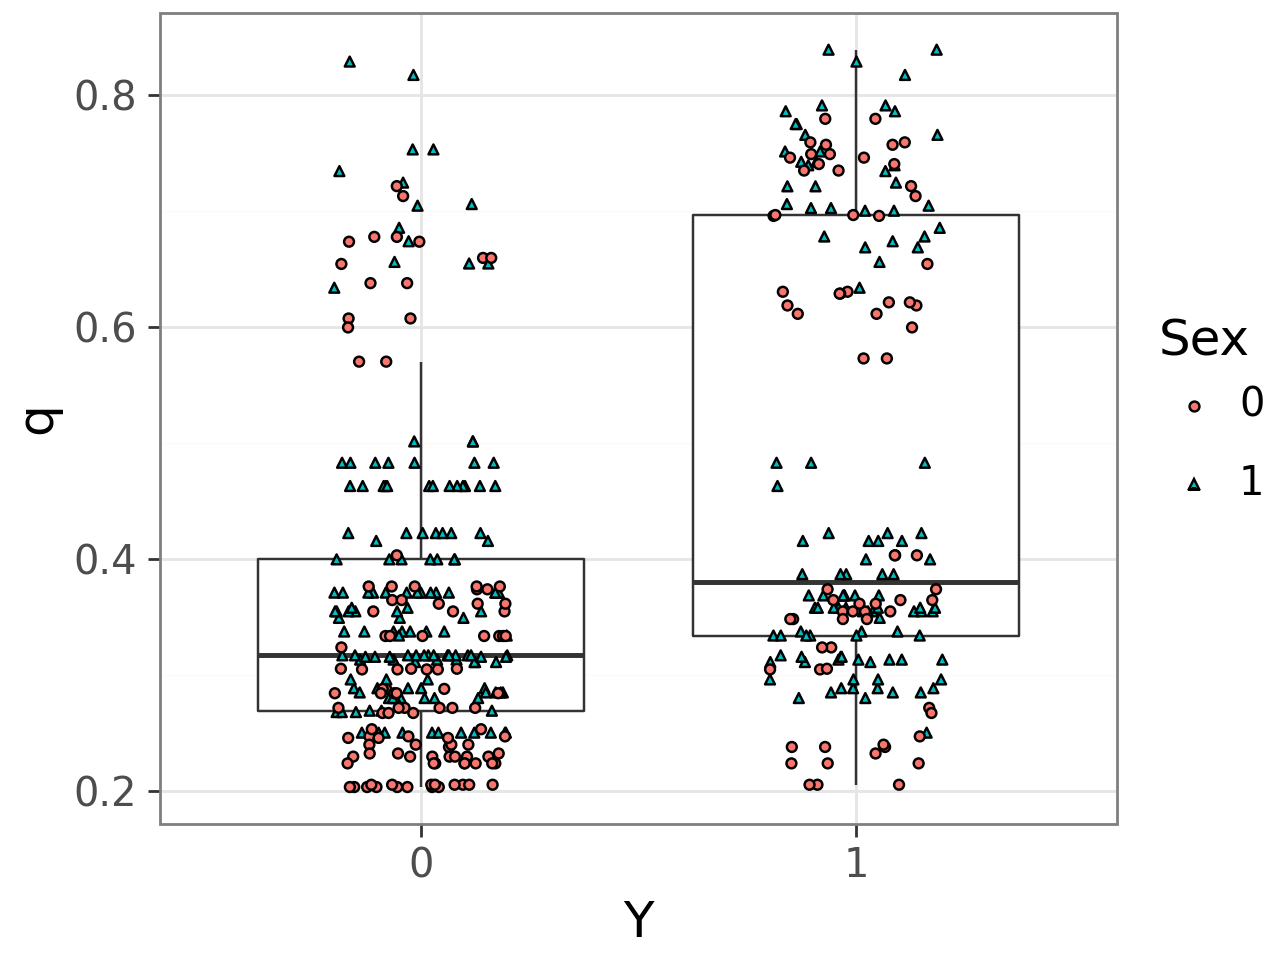

In [48]:
import pandas
import cmdstanpy
import numpy as np
from plotnine import *

np.random.seed(123)

d = pandas.read_csv('input/data-shopping-3.csv')
# fit = cmdstanpy.from_csv('output/result-model5-5')
q_ms = fit.stan_variable(var='q')
qua = np.quantile(q_ms, [0.1, 0.50, 0.9], axis=0)
d_qua = pandas.DataFrame(qua.T, columns=['10%', '50%', '90%'])
d_comp = pandas.concat([d, d_qua], axis=1)

p = (ggplot(d_comp, aes(x='factor(Y)', y='50%'))
    + theme_bw(base_size=18)
    + geom_boxplot(outlier_alpha=0)
    + geom_point(aes(fill='factor(Sex)', shape='factor(Sex)'), position=position_jitter(width=0.2, height=0), size=1.5)
    + scale_shape_manual(values=['o', '^'])
    + labs(x='Y', y='q', fill='Sex', shape='Sex')
)
# p.save(filename='output/fig5-7-left.py.png', dpi=300, width=5, height=4)
p.show()


In [52]:
d_comp.head()

PersonID  Sex  Income  Discount  Y      10%       50%       90%
0         1    0    85.1         0  1  0.29492  0.354836  0.419122
1         1    0    85.1         1  1  0.66905  0.740585  0.801086
2         1    0    85.1         0  0  0.29492  0.354836  0.419122
3         1    0    85.1         0  1  0.29492  0.354836  0.419122
4         1    0    85.1         1  1  0.66905  0.740585  0.801086

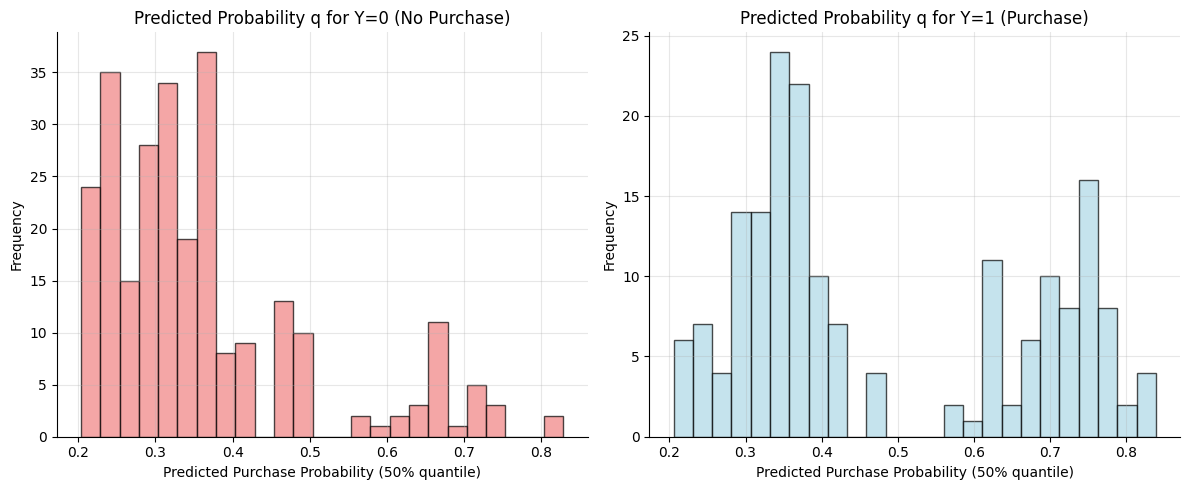

In [53]:
# Create histograms for d_comp['50%'] separated by Y values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Filter data by Y values
y_0_data = d_comp[d_comp['Y'] == 0]['50%']
y_1_data = d_comp[d_comp['Y'] == 1]['50%']

# Histogram for Y=0 (No Purchase)
ax1.hist(y_0_data, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
ax1.set_title('Predicted Probability q for Y=0 (No Purchase)')
ax1.set_xlabel('Predicted Purchase Probability (50% quantile)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Histogram for Y=1 (Purchase)
ax2.hist(y_1_data, bins=25, alpha=0.7, color='lightblue', edgecolor='black')
ax2.set_title('Predicted Probability q for Y=1 (Purchase)')
ax2.set_xlabel('Predicted Purchase Probability (50% quantile)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [56]:
d_comp.PersonID.value_counts()[:3]

PersonID
22    16
34    16
16    16
Name: count, dtype: int64

In [ ]:
d22 = d_comp[d_comp['PersonID'] == 22]
d22

PersonID  Sex  Income  Discount  Y       10%       50%       90%
198        22    1    59.1         0  0  0.277547  0.316977  0.360891
199        22    1    59.1         0  0  0.277547  0.316977  0.360891
200        22    1    59.1         0  0  0.277547  0.316977  0.360891
201        22    1    59.1         0  1  0.277547  0.316977  0.360891
202        22    1    59.1         0  0  0.277547  0.316977  0.360891
203        22    1    59.1         0  0  0.277547  0.316977  0.360891
204        22    1    59.1         0  0  0.277547  0.316977  0.360891
205        22    1    59.1         0  0  0.277547  0.316977  0.360891
206        22    1    59.1         1  1  0.638081  0.706104  0.771768
207        22    1    59.1         0  0  0.277547  0.316977  0.360891
208        22    1    59.1         0  0  0.277547  0.316977  0.360891
209        22    1    59.1         0  0  0.277547  0.316977  0.360891
210        22    1    59.1         1  0  0.638081  0.706104  0.771768
211        22    1    59.1         0  0  0.277547  0.316977  0.360891
212        22    1    59.1         0  0  0.277547  0.316977  0.360891
213        22    1    59.1         0  0  0.277547  0.316977  0.360891

Text(0.5, 1.0, 'Posterior Distribution of Predicted Probability q for PersonID 22')

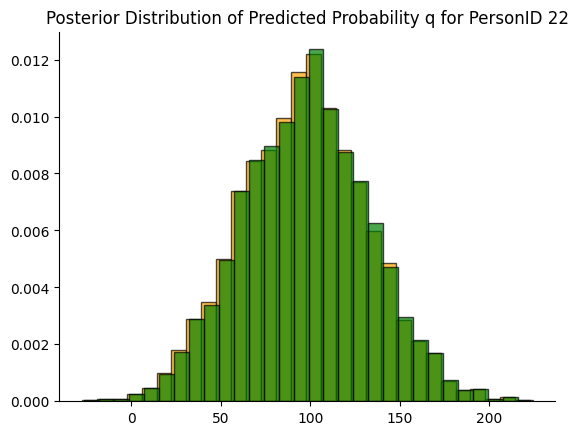

In [85]:
discount_value = 0  # Set discount value to 0 or 1 as needed
q22_d0 = b_params['b[1]'] + b_params['b[2]'] * d22.Sex.iloc[0] + b_params['b[3]'] * d22.Income.iloc[0] + b_params['b[4]'] * discount_value
discount_value = 1
q22_d1 = b_params['b[1]'] + b_params['b[2]'] * d22.Sex.iloc[0] + b_params['b[3]'] * d22.Income.iloc[0] + b_params['b[4]'] * discount_value
# Summary statistics
plt.hist(q22_d0, bins=30, alpha=0.7, label='Discount=0', color='orange', edgecolor='black', density=True)
plt.hist(q22_d1, bins=30, alpha=0.7, label='Discount=1', color='green', edgecolor='black', density=True)
plt.title('Posterior Distribution of Predicted Probability q for PersonID 22')

In [15]:
import numpy as np

def logit(x):
    return 1 / (1 + np.exp(-x))

In [16]:
q = logit(b_params['b[1]'] + b_params['b[2]'] * d.Sex[0] + b_params['b[3]'] * d.Income[0])
print(q.describe())
print(q.head())

count    4000.000000
mean        0.466457
std         0.046549
min         0.313664
25%         0.434688
50%         0.466592
75%         0.497047
max         0.624773
dtype: float64
0    0.462663
1    0.409946
2    0.443530
3    0.515770
4    0.439777
dtype: float64


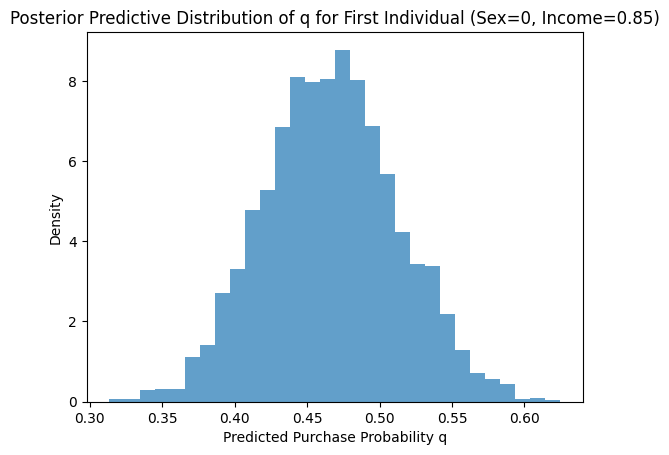

In [17]:
plt.hist(q, bins=30, alpha=0.7, density=True)
plt.xlabel('Predicted Purchase Probability q')
plt.ylabel('Density')
plt.title(f'Posterior Predictive Distribution of q for First Individual (Sex={d.Sex[0]}, Income={d.Income[0]:.2f})')
plt.show()

[2 5 5 ... 5 5 3] shape: (4000,)
The number of visits: 9


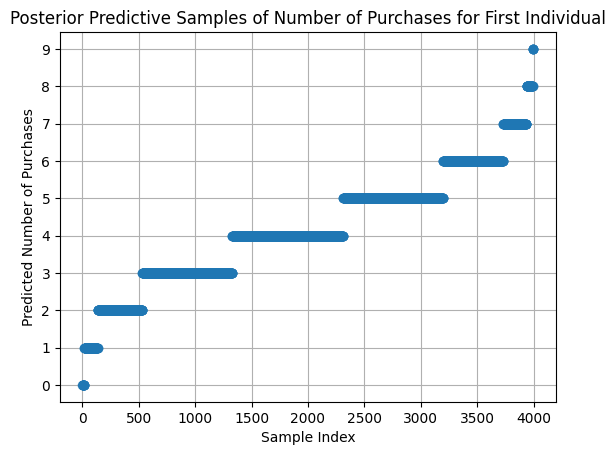

In [18]:
# predictive sampling
import scipy.stats as stats
y_pred_samples = stats.binom.rvs(n=int(d.M[0]), p=q, size=len(q))
print(y_pred_samples, "shape:", y_pred_samples.shape)

print("The number of visits:", int(d.M[0]))

y_pred_samples = np.sort(y_pred_samples) # sort for better visualization

plt.plot(y_pred_samples, marker='o', linestyle='', alpha=0.7);
plt.yticks(range(int(d.M[0])+1))
plt.xlabel('Sample Index')
plt.ylabel('Predicted Number of Purchases')
plt.title('Posterior Predictive Samples of Number of Purchases for First Individual')
plt.grid(True)
plt.show()

CORRECT binning for discrete data 0 to 9:
Bin edges: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Number of bins: 10
Bins represent: [0,1), [1,2), [2,3), ..., [9,10)
This captures all values 0,1,2,...,9

Density values: [0.004   0.03    0.09875 0.19925 0.246   0.2215  0.13325 0.05175 0.014
 0.0015 ]
Sum of densities × bin_width: 1.0000000000000002 (should be 1.0 for density=True)

Data verification:
Min value in data: 0
Max value in data: 9
All values captured: True


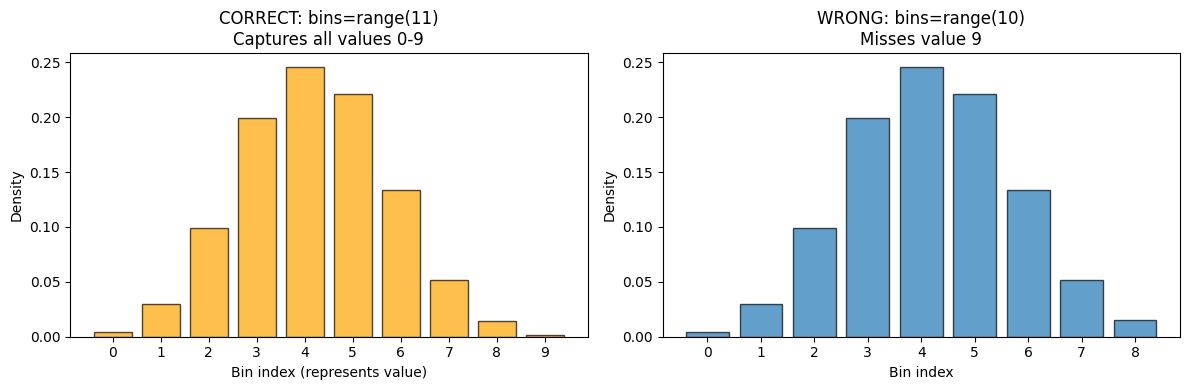

In [19]:
# Correct way to handle discrete data for complete range 0 to M

# Problem: bins=range(int(d.M[0])+1) gives [0,1,2,...,9] 
# This creates bins [0,1), [1,2), ..., [8,9) - missing values that equal 9!

# Solution: Use bins=range(int(d.M[0])+2) to include all possible values
correct_bins = range(int(d.M[0]) + 2)  # [0, 1, 2, ..., 9, 10]
correct_counts, correct_edges = np.histogram(y_pred_samples, bins=correct_bins, density=True)

print("CORRECT binning for discrete data 0 to 9:")
print(f"Bin edges: {list(correct_edges)}")
print(f"Number of bins: {len(correct_counts)}")
print(f"Bins represent: [0,1), [1,2), [2,3), ..., [9,10)")
print(f"This captures all values 0,1,2,...,9")

print(f"\nDensity values: {correct_counts}")
print(f"Sum of densities × bin_width: {np.sum(correct_counts)} (should be 1.0 for density=True)")

# Verify no data is lost
print(f"\nData verification:")
print(f"Min value in data: {y_pred_samples.min()}")
print(f"Max value in data: {y_pred_samples.max()}")
print(f"All values captured: {y_pred_samples.min() >= 0 and y_pred_samples.max() < 10}")

# Compare the two approaches
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 4))

# Wrong way (missing data at boundary)
wrong_counts, wrong_edges = np.histogram(y_pred_samples, bins=range(int(d.M[0])+1), density=True)
ax1.bar(range(len(wrong_counts)), wrong_counts, alpha=0.7, edgecolor='black')
ax1.set_title('WRONG: bins=range(10)\nMisses value 9')
ax1.set_xlabel('Bin index')
ax1.set_ylabel('Density')
ax1.set_xticks(range(len(wrong_counts)))

# Correct way
ax2.bar(correct_bins[:-1], correct_counts, alpha=0.7, edgecolor='black', color='orange')
ax2.set_title('CORRECT: bins=range(11)\nCaptures all values 0-9')
ax2.set_xlabel('Bin index (represents value)')
ax2.set_ylabel('Density')
ax2.set_xticks(range(len(correct_counts)))

plt.tight_layout()
plt.show()

끝.